In [1]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np

mpl.rcParams["figure.dpi"] = 100
mpl.rcParams["savefig.bbox"] = "tight"
mpl.rcParams["savefig.dpi"] = 300

import seaborn as sns
sns.set_context("paper")

### Curtis et al. 2020 gyrochrones

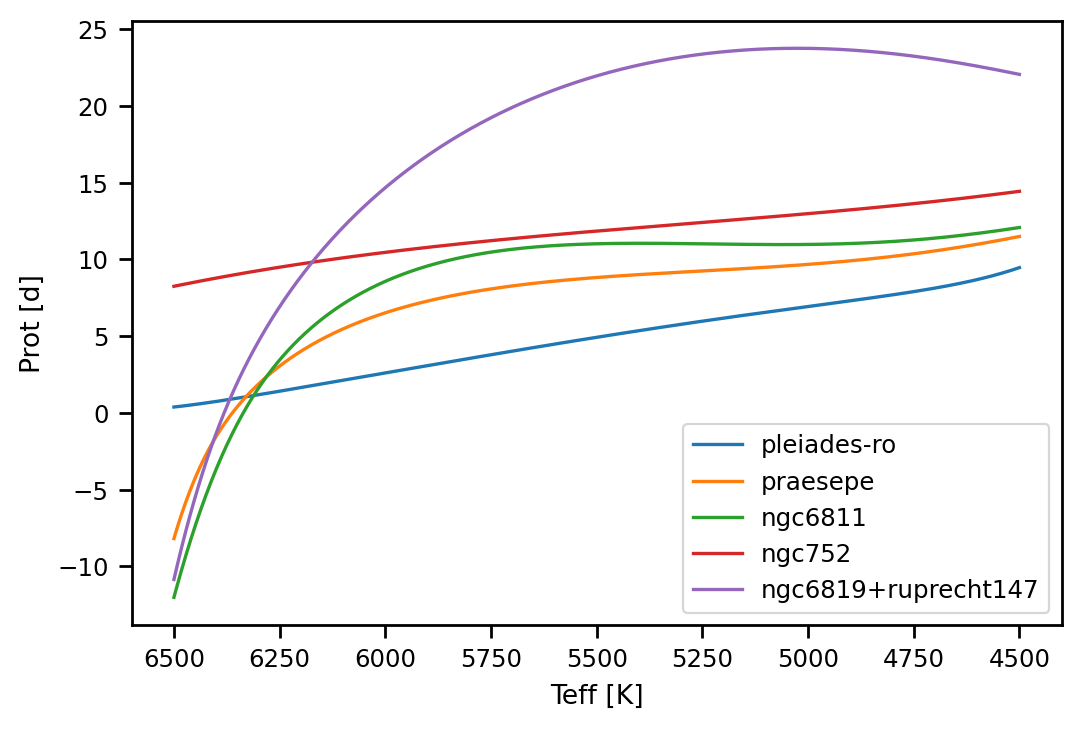

In [2]:
# Curtis et al. 2020 table
def curtis_bprp_teff(bprp):
    #Estimating effective temperature from the dereddened Gaia DR2 (Bp-Rp) color
    bprp  = np.array(bprp)
    coeff = [-416.585, 39780.0, -84190.5, 85203.9, -48225.9, 15598.5, -2694.76, 192.865]    
    teff  = np.array([np.sum([co*_bprp**i for i,co in enumerate(coeff)]) for _bprp in bprp])
    mask  = (bprp>=0.55) & (bprp<=3.25)
    teff[~mask] = np.nan
    return teff

def curtis_gyrochrone(bprp, kind):
    bprp = np.array(bprp)
    
    if kind=='kepler': #Kepler lower envelope
        bprp_min, bprp_max = 0.6, 2.1
        coeff = [36.4756, -202.718, 414.752, -395.161, 197.800, -50.0287, 5.05738]
        
    elif kind=='pleiades-ro':
        bprp_min, bprp_max = 0.6, 1.3
        coeff = [37.068, -188.02, 332.32, -235.78, 60.395]

    elif kind=='pleiades-quad':
        bprp_min, bprp_max = 0.6, 1.3
        coeff = [-8.467, 19.64, -5.438]
        
    elif kind=='praesepe':
        bprp_min, bprp_max = 0.6, 2.4
        coeff = [-330.810, 1462.48, -2569.35, 2347.13, -1171.90, 303.620, -31.9227]
        
    elif kind=='ngc6811':
        bprp_min, bprp_max = 0.65, 1.95 
        coeff = [-594.019, 2671.90, -4791.80, 4462.64, -2276.40, 603.772, -65.0830]
        
    elif kind=='ngc752':
        bprp_min, bprp_max = 1.32, 2.24
        coeff = [6.80, 5.63] 
    
    elif kind=='ngc6819+ruprecht147':
        bprp_min, bprp_max = 0.62, 2.07
        coeff = [-271.783, 932.879, -1148.51, 695.539, -210.562, 25.8119]
        
    prot  = np.array([np.sum([co*_bprp**i for i,co in enumerate(coeff)]) for _bprp in bprp])
    mask  = (bprp>=bprp_min) & (bprp<=bprp_max)
    prot[~mask] = np.nan
    
    return prot
        

#Re-casting the Curtis et al. 2020 polynomial relations in Teff

from scipy import interpolate

def curtis_teff_gyrochrone(teff, kind):
    
    _bprp = np.linspace(0,5,10000)
    _teff = curtis_bprp_teff(_bprp)
    _prot = curtis_gyrochrone(_bprp, kind)
    
    _ = (np.isfinite(_teff)) & (np.isfinite(_prot))
    
    # Be cognizant that using "extrapolate" means the resulting relations will be unreliable
    # outside the Teff ranges over which they were derived, but for our purposes it is effective 
    f = interpolate.interp1d(_teff[_], _prot[_], kind='cubic', fill_value='extrapolate')
    
    return f(teff)


def curtis_teff_bprp(teff):
    #Invert Teff-BpRp relation
    
    _bprp = np.linspace(0.55,3.25,10000)
    _teff = curtis_bprp_teff(_bprp)
    
    _ = (np.isfinite(_teff)) & (np.isfinite(_bprp))
    
    # Be cognizant that using "extrapolate" means the resulting relations will be unreliable
    # outside the Teff ranges over which they were derived, but for our purposes it is effective 
    f = interpolate.interp1d(_teff[_], _bprp[_], kind='cubic', fill_value='extrapolate')
    
    return f(teff)


sequences = ['pleiades-ro', 'praesepe', 'ngc6811', 'ngc752', 'ngc6819+ruprecht147']

_teff = np.linspace(4500,6500,1000)

for seq in sequences:
    plt.plot(_teff, curtis_teff_gyrochrone(_teff, kind=seq), label=seq)

plt.legend()
plt.xlabel('Teff [K]')
plt.ylabel('Prot [d]')
plt.gca().invert_xaxis()    
plt.show()

In [26]:
cks = pd.read_parquet('../data/data.parquet')
# The dataframe has a row entry for each KOI, meaning individual star are represented N times
# where N is the number of KOIs detected around that star so we drop duplicates.
print(np.shape(cks))
cks = cks.drop_duplicates(subset=['kepid'], keep='first')
print(np.shape(cks))
cks.head()

(9750, 1371)
(8214, 1371)


,kepid,kepoi_name,kepler_name,ra,ra_err,ra_str,dec,dec_err,dec_str,koi_gmag,...,bf18_e_[Na/N],bf18_[Na/C],bf18_e_[Na/C],bf18_[O/N],bf18_e_[O/N],bf18_[O/C],bf18_e_[O/C],bf18_[N/C],bf18_e_[N/C],bf18_[alpha/Fe]
0,10797460,K00752.01,Kepler-227 b,291.93423,0.0,19h27m44.22s,48.141651,0.0,+48d08m29.9s,15.890,...,0.155563,-0.04,0.056569,0.10,0.155563,0.08,0.056569,-0.02,0.056569,-0.010000
2,10811496,K00753.01,None,297.00482,0.0,19h48m01.16s,48.134129,0.0,+48d08m02.9s,15.943,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10848459,K00754.01,None,285.53461,0.0,19h02m08.31s,48.285210,0.0,+48d17m06.8s,16.100,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10854555,K00755.01,Kepler-664 b,288.75488,0.0,19h15m01.17s,48.226200,0.0,+48d13m34.3s,16.015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,10872983,K00756.01,Kepler-228 d,296.28613,0.0,19h45m08.67s,48.224670,0.0,+48d13m28.8s,16.234,...,0.197990,-0.07,0.070711,0.33,0.197990,0.01,0.070711,-0.32,0.070711,-0.006667


In [27]:
std = pd.read_csv('../models/standard_model.csv')
roc = pd.read_csv('../models/rocrit_model.csv')

std['flag'] = 'std'
roc['flag'] = 'roc'

model = pd.concat([std, roc], ignore_index=True, sort=True)
model.head()

,Age(Gyr),Mass(Msun),Prot(days),Ro,Teff(K),flag
0,2.343081,0.39749,3.132252,0.028923,3425.943077,std
1,1.110579,0.38310,0.769080,0.007271,3426.052848,std
2,1.162998,0.40312,0.830315,0.008025,3429.332363,std
3,1.398936,0.39909,1.067847,0.009989,3425.867537,std
4,2.144391,0.39106,2.477922,0.022913,3425.887204,std


# Kepler-LAMOST cross-match from Jason Curtis

In [28]:
lam = pd.read_csv('../data/KeplerRot-LAMOST.csv')
lam.head()

#From Jason:
#ik = (lam['Gmag']<15) & ((lam['Gmag']-5*np.log10(100/lam['parallax']))>3.5) & (lam['logg_lam']>3.8)
ik = (lam['Gmag']<15) & ((lam['Gmag']-5*np.log10(100/lam['parallax']))>3.5) & (lam['logg_lam']>4)

/Users/tdavid/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


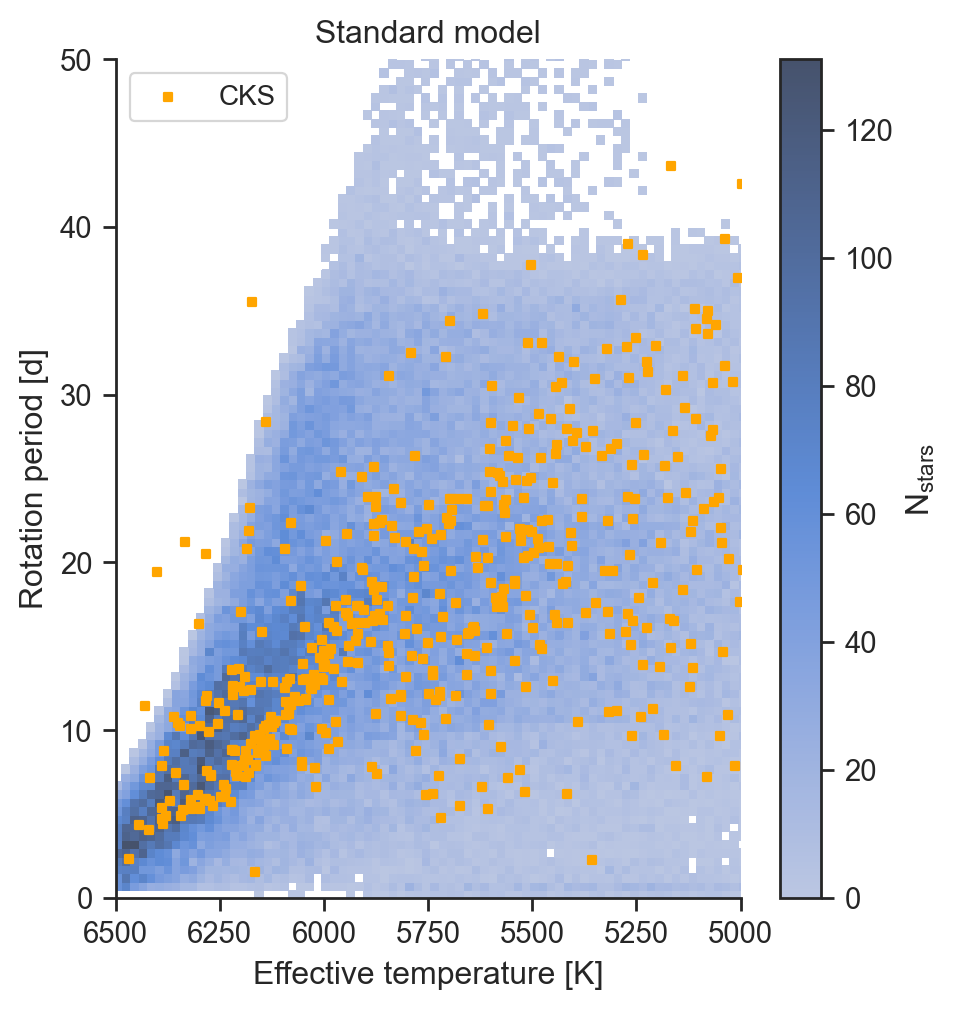

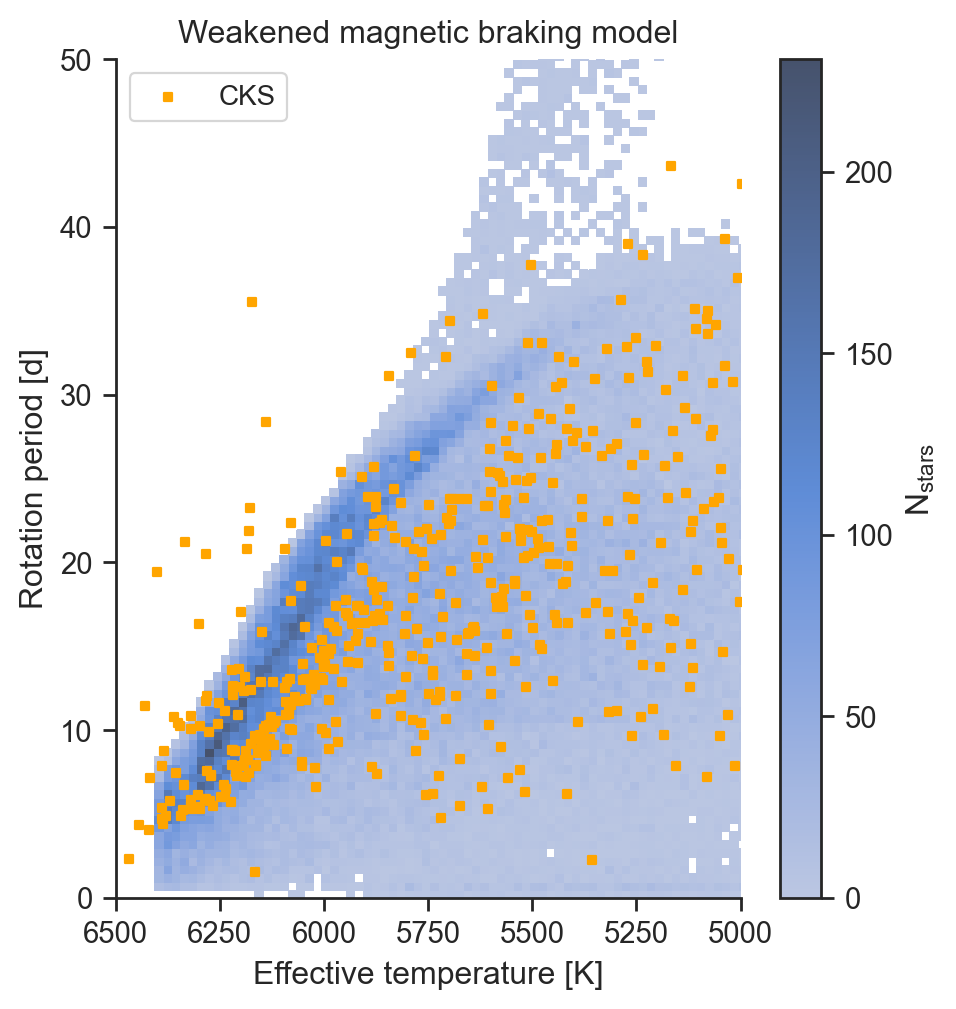

In [59]:
mpl.rcParams["legend.markerscale"] = 1
sns.set(font_scale=1.2, context="paper", style="ticks")
sc_kws = {"marker":",", "color":"orange", "s":8, "rasterized":True}

sns.displot(data=std, x="Teff(K)", y="Prot(days)", binwidth=(20, 0.5), cbar=True, cbar_kws={'label': r'N$_\mathregular{stars}$'})
plt.scatter(cks['cks_Teff'], cks['d21_prot'], label='CKS', **sc_kws)
plt.gca().invert_xaxis()
plt.xlim(6500,5000)
plt.ylim(0,50)
plt.legend(loc='upper left', prop={"size":10})
plt.title('Standard model')
plt.xlabel('Effective temperature [K]')
plt.ylabel('Rotation period [d]')
plt.savefig('../figures/std-model-cks.pdf')
plt.show()


sns.displot(data=roc, x="Teff(K)", y="Prot(days)", binwidth=(20, 0.5), cbar=True, cbar_kws={'label': r'N$_\mathregular{stars}$'})
plt.scatter(df['cks_Teff'], df['d21_prot'], label='CKS', **sc_kws)
plt.gca().invert_xaxis()
plt.xlim(6500,5000)
plt.ylim(0,50)
plt.legend(loc='upper left', prop={"size":10})
plt.title('Weakened magnetic braking model')
plt.xlabel('Effective temperature [K]')
plt.ylabel('Rotation period [d]')
plt.savefig('../figures/wmb-model-cks.pdf')
plt.show()

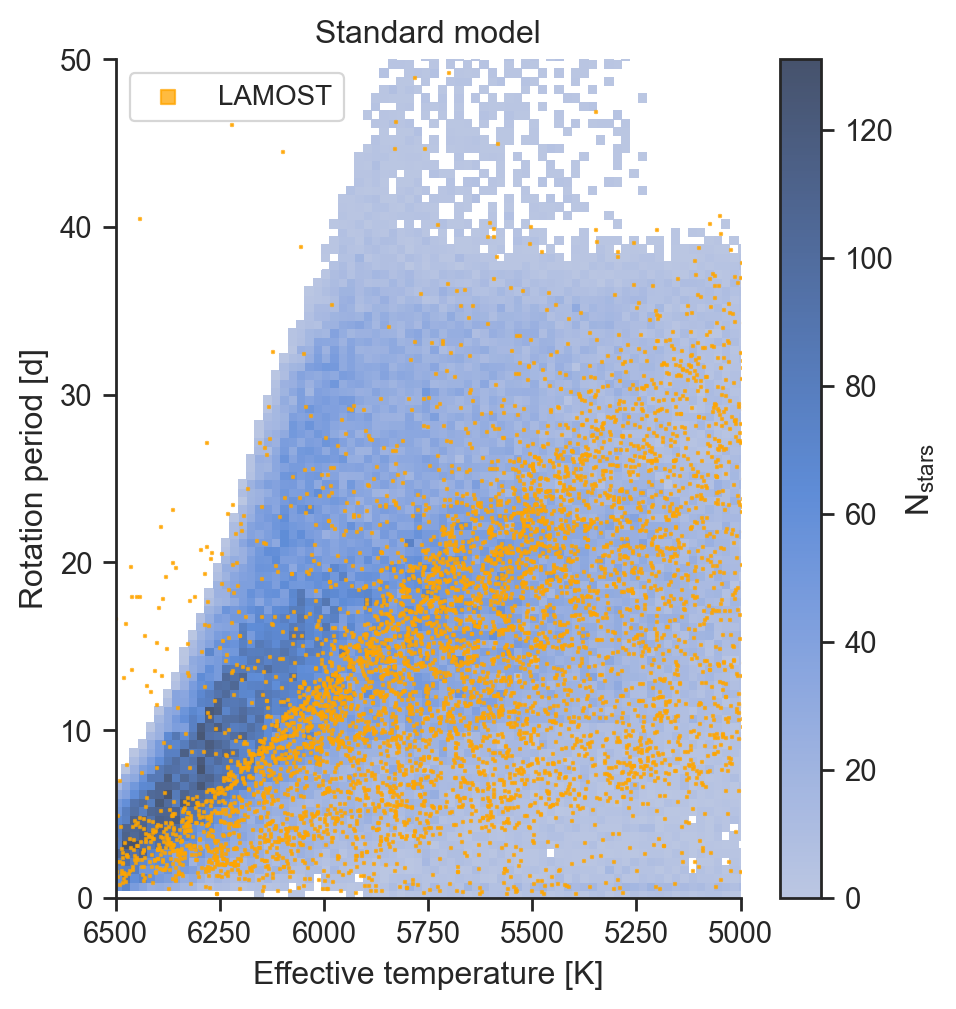

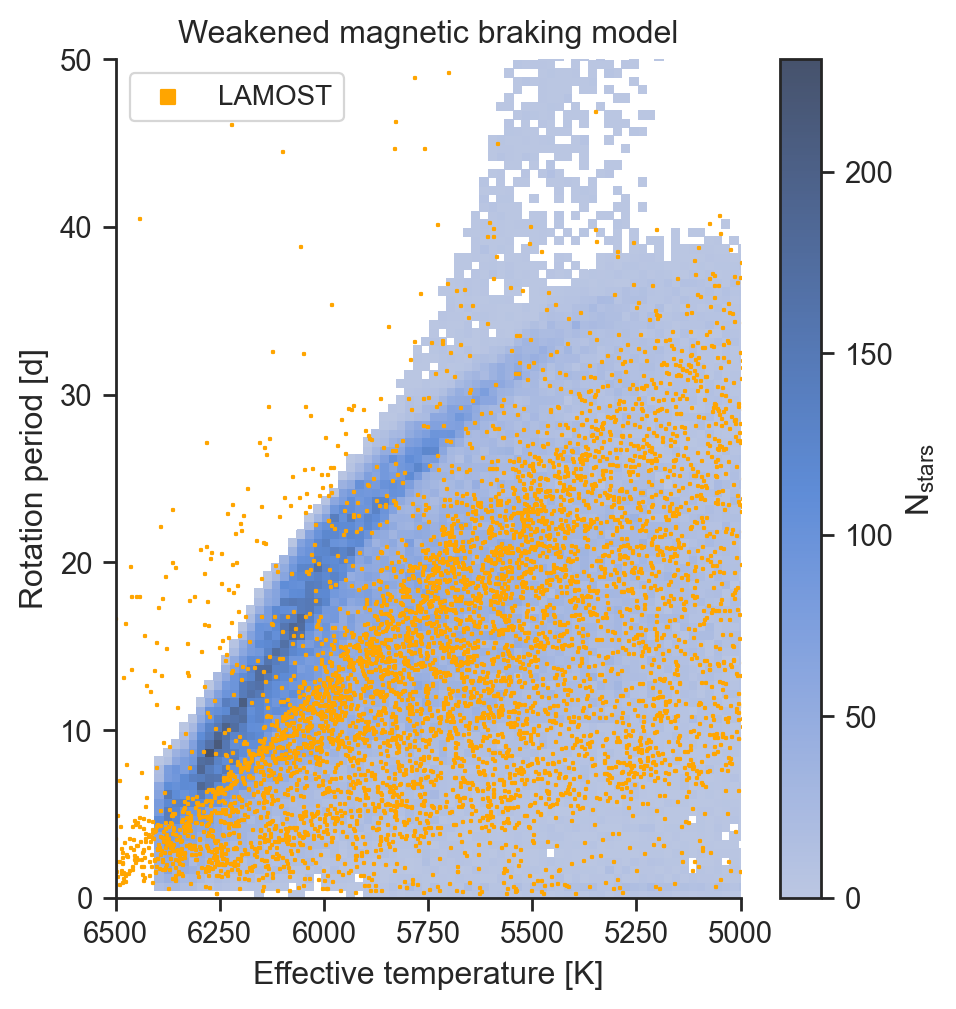

In [56]:
mpl.rcParams["legend.markerscale"] = 5
sns.set(font_scale=1.2, context="paper", style="ticks")
sc_kws = {"marker":",", "color":"orange", "s":1, "rasterized":True, "alpha":0.75}

sns.displot(data=std, x="Teff(K)", y="Prot(days)", binwidth=(20, 0.5), cbar=True, cbar_kws={'label': r'N$_\mathregular{stars}$'})
plt.scatter(klam['Teff_lam'][ik], klam['Prot'][ik], label='LAMOST', **sc_kws)
plt.gca().invert_xaxis()
plt.xlim(6500,5000)
plt.ylim(0,50)
plt.legend(loc='upper left', prop={"size":10})
plt.title('Standard model')
plt.xlabel('Effective temperature [K]')
plt.ylabel('Rotation period [d]')
plt.savefig('../figures/std-model-lamost.pdf')
plt.show()

sns.displot(data=roc, x="Teff(K)", y="Prot(days)", binwidth=(20, 0.5), cbar=True, cbar_kws={'label': r'N$_\mathregular{stars}$'})
plt.scatter(klam['Teff_lam'][ik], klam['Prot'][ik], label='LAMOST', **pl_kws)
plt.gca().invert_xaxis()
plt.xlim(6500,5000)
plt.ylim(0,50)
plt.legend(loc='upper left', prop={"size":10})
plt.title('Weakened magnetic braking model')
plt.xlabel('Effective temperature [K]')
plt.ylabel('Rotation period [d]')
plt.savefig('../figures/wmb-model-lamost.pdf')
plt.show()

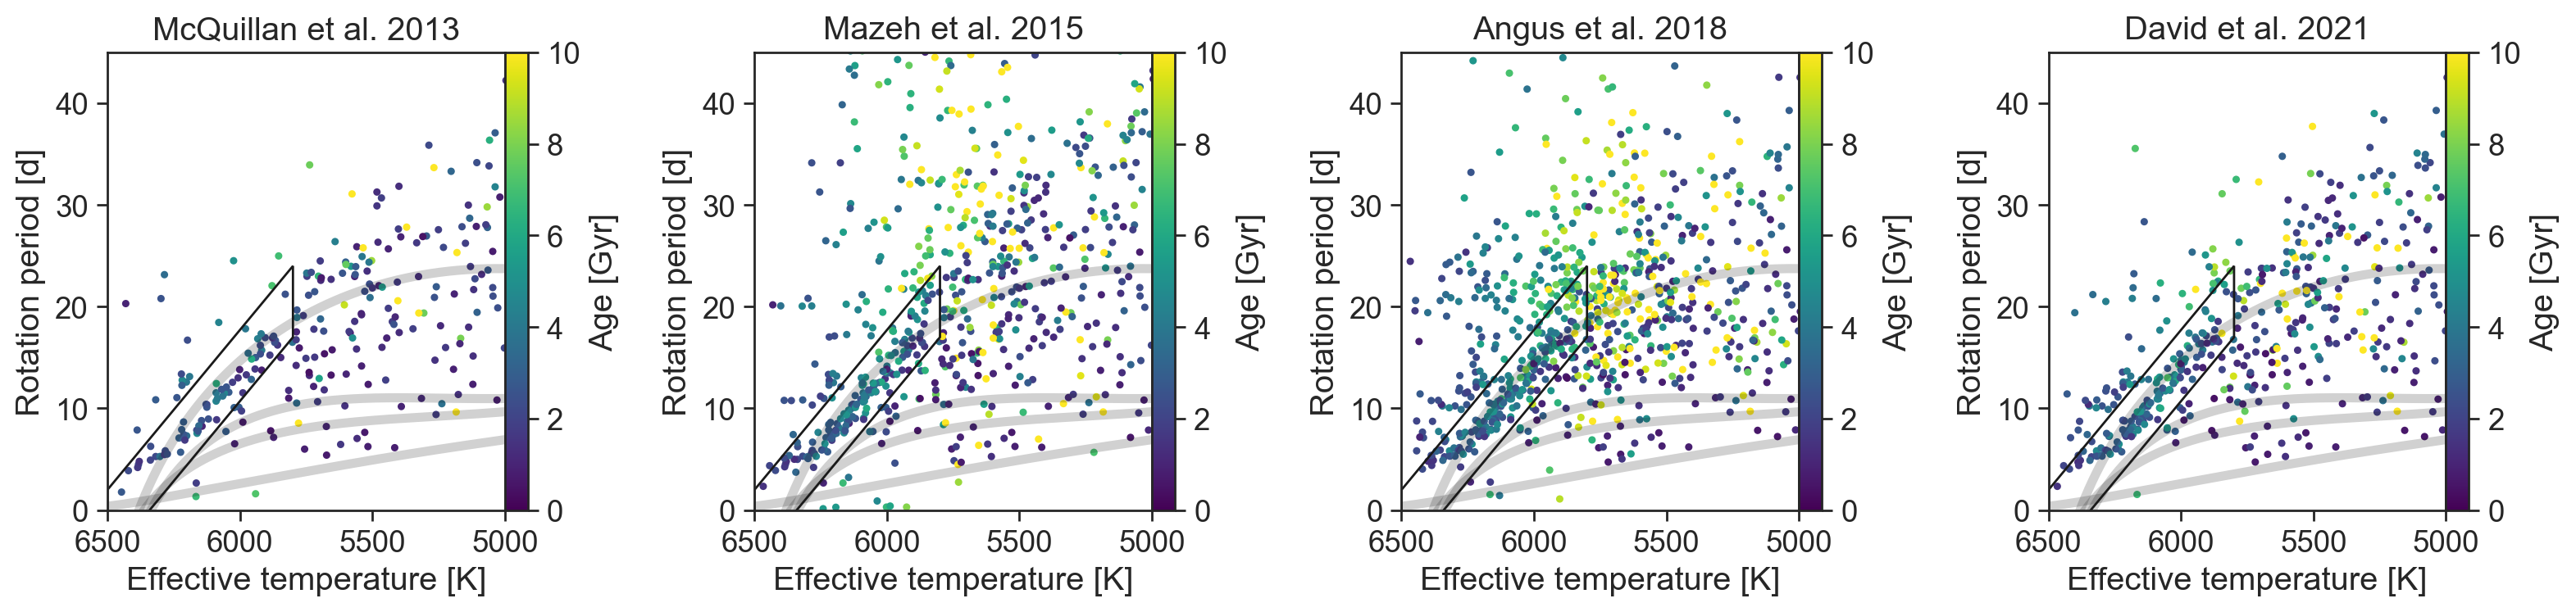

In [264]:
sns.set(font_scale=1.5, context="paper", style="ticks")

def ridge_hi(teff):
    m = (2-24)/(6500-5800)
    b = (2 - m*6500) 
    return m*teff + b

def ridge_lo(teff):
    m = (2-24)/(6500-5800)
    b = (-5 - m*6500) 
    return m*teff + b



ridge = (df['p20_cks_steff']>5800)
ridge &= (df['p20_cks_steff']<6500)
ridge &= (df['d21_prot']<ridge_hi(df['p20_cks_steff']))
ridge &= (df['d21_prot']>ridge_lo(df['p20_cks_steff']))
ridge &= mask

# Parallelogram
xp = [6500,6500,5800,5800]
yp = [ridge_lo(6500),ridge_hi(6500),ridge_hi(5800),ridge_lo(5800)]


mask = (df['p20_cks_slogg']>4) #main sequence

x = df['cks_Teff']
ys = [df['m13_Prot'], df['m15_Prot'], df['a18_period'], df['d21_prot']]
labels = ['McQuillan et al. 2013','Mazeh et al. 2015', 'Angus et al. 2018','David et al. 2021']

sc_kws = {'cmap':'viridis', 's':6, 'vmin':0, 'vmax':10, 'alpha':1, 'rasterized':True}

gyro_sequences = ['pleiades-ro', 'praesepe', 'ngc6811', 'ngc6819+ruprecht147']

fig, ax = plt.subplots(nrows=1, ncols=len(ys), figsize=(0.8*20,0.8*5))

for i,y in enumerate(ys):
    sc1 = ax[i].scatter(x[mask], y[mask], c=df['cks_age'][mask], **sc_kws)
    
    cb1 = fig.colorbar(sc1, ax=ax[i], pad=0)
    #cb2 = fig.colorbar(sc2, ax=ax[1][i], pad=0)    
    
    ax[i].set_title(labels[i])
    ax[i].set_ylim(0,45)
    ax[i].set_xlim(6500,5000)
    #ax[i].invert_xaxis()
    ax[i].set_ylabel('Rotation period [d]')
    ax[i].set_xlabel('Effective temperature [K]')
    cb1.set_label('Age [Gyr]')
    
    
    #if i==4:
    #    cb1.set_label('[Y/Mg] Age [Gyr]')
        #cb2.set_label('[Y/Mg] Age [Gyr]')
        
    _teff = np.linspace(4500,6500,1000)

    for seq in gyro_sequences:
        ax[i].plot(_teff, curtis_teff_gyrochrone(_teff, kind=seq), label=seq, color='k', lw=4, alpha=0.2)
        
        
    #Parallelogram
    ax[i].add_patch(patches.Polygon(xy=list(zip(xp,yp)), fill=False, lw=1, color='k'))
    
plt.tight_layout()
plt.savefig('../figures/ridge.pdf')
plt.show()

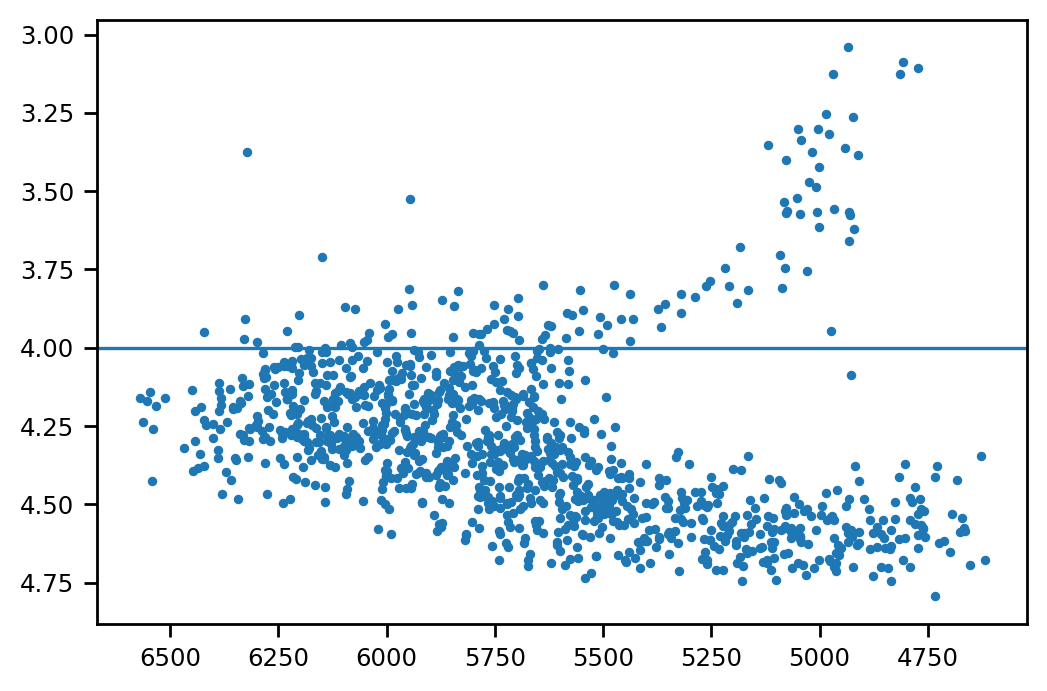

In [125]:
plt.plot(df['p20_cks_steff'], df['p20_cks_slogg'], '.')
plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
plt.axhline(4)
plt.show()

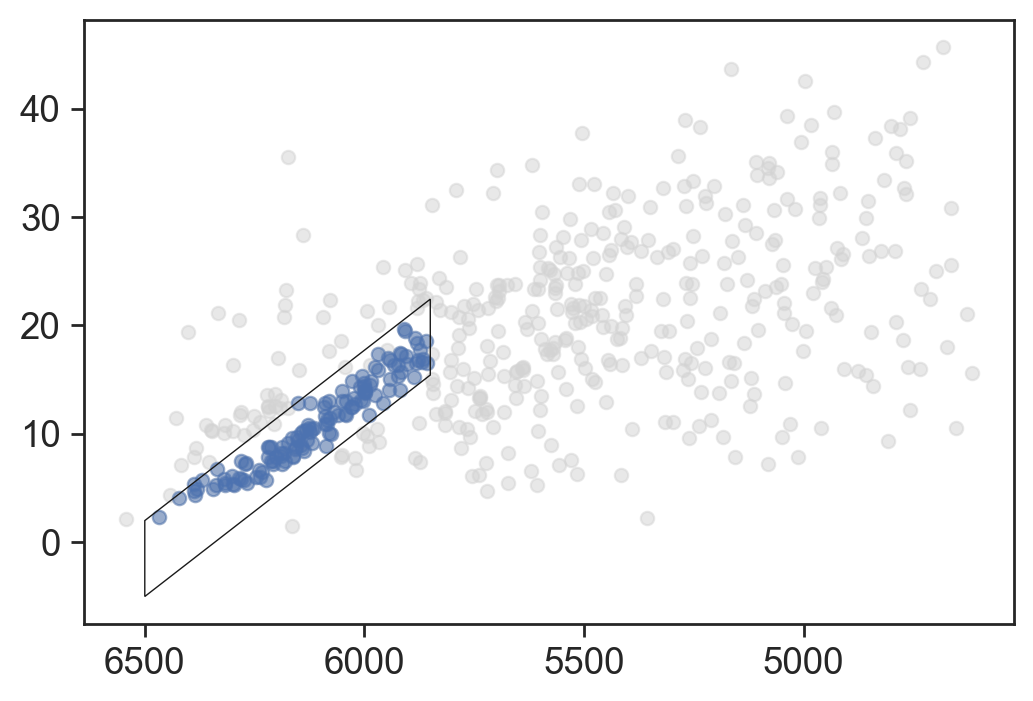

In [360]:
import matplotlib.patches as patches

fig = plt.figure()
ax = fig.add_subplot(111)


def ridge_hi(teff):
    m = (2-24)/(6500-5800)
    b = (2 - m*6500) 
    return m*teff + b

def ridge_lo(teff):
    m = (2-24)/(6500-5800)
    b = (-5 - m*6500) 
    return m*teff + b



ridge = (df['p20_cks_steff']>5850)
ridge &= (df['p20_cks_steff']<6500)
ridge &= (df['d21_prot']<ridge_hi(df['p20_cks_steff']))
ridge &= (df['d21_prot']>ridge_lo(df['p20_cks_steff']))
ridge &= mask


# Parallelogram
x = [6500,6500,5850,5850]
y = [ridge_lo(6500),ridge_hi(6500),ridge_hi(5850),ridge_lo(5850)]
ax.add_patch(patches.Polygon(xy=list(zip(x,y)), fill=False, lw=0.5, color='k'))

#ax.scatter(df['p20_cks_steff'], df['a18_period'], color='lightgrey', alpha=0.2)
ax.scatter(df['p20_cks_steff'], df['d21_prot'], color='lightgrey', alpha=0.5)
ax.scatter(df['p20_cks_steff'][ridge], df['d21_prot'][ridge], alpha=0.5)
ax.invert_xaxis()
#ax.plot(_teff, ridge_hi(_teff), 'k--')
#ax.plot(_teff, ridge_lo(_teff), 'k--')
plt.show()

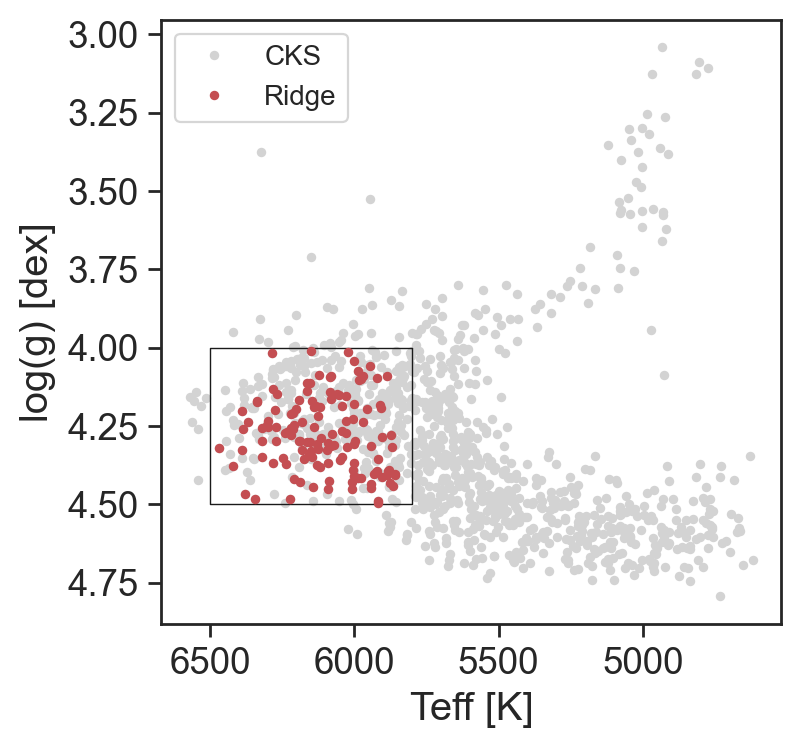

In [361]:
all_f = mask & (df['p20_cks_steff']>5800) & (df['p20_cks_slogg']<4.5) & (df['p20_cks_steff']<6500)

fig,ax=plt.subplots(figsize=(4,4))

ax.plot(df['p20_cks_steff'], df['p20_cks_slogg'], '.', color='lightgrey', label='CKS')
#ax.plot(df['p20_cks_steff'][all_f], df['p20_cks_slogg'][all_f], 'o', color='lightgrey', mec='k')
#ax.plot(df['p20_cks_steff'][all_f], df['p20_cks_slogg'][all_f], 'o', color='lightgrey', ms=3)
ax.plot([5800,6500,6500,5800,5800],[4.,4.,4.5,4.5,4.],color='k',lw=0.5)
ax.plot(df['p20_cks_steff'][ridge], df['p20_cks_slogg'][ridge], '.', color='r', label='Ridge')
ax.invert_yaxis()
ax.invert_xaxis()
#ax.axhline(4, color='grey', lw=0.5)
ax.set_ylabel('log(g) [dex]')
ax.set_xlabel('Teff [K]')
ax.legend(prop={'size':10}, loc='upper left')
plt.show()

/Users/tdavid/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/tdavid/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/tdavid/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar 

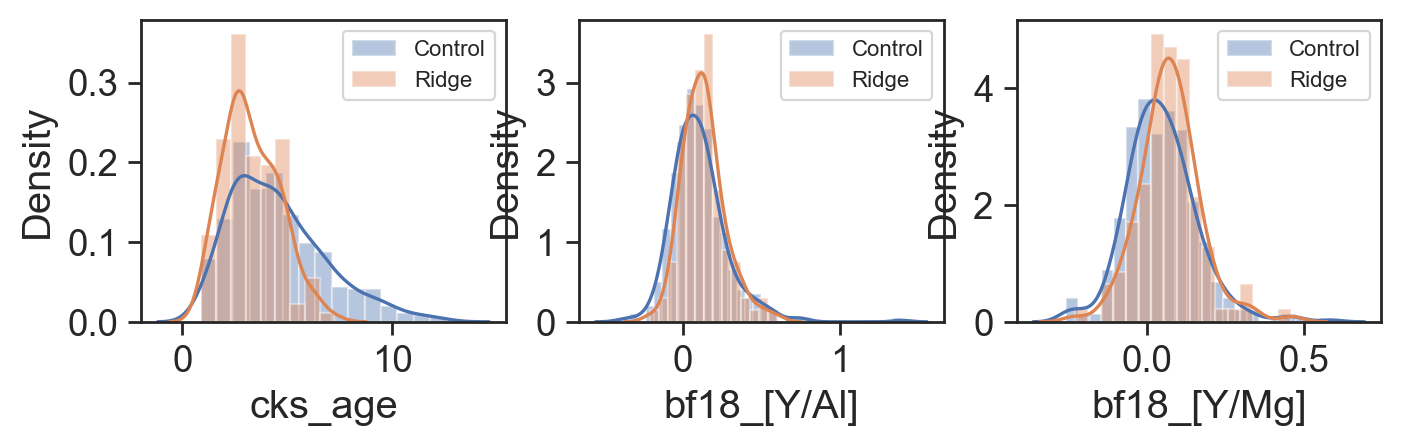

In [362]:
all_f = mask & (cks['p20_cks_steff']>5800) & (cks['p20_cks_slogg']<4.5) & (cks['p20_cks_steff']<6500)



fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3, figsize=(8,2))


sns.distplot(cks['cks_age'][all_f], label='Control', ax=ax1)
sns.distplot(cks['cks_age'][ridge], label='Ridge', ax=ax1)

sns.distplot(cks['bf18_[Y/Al]'][all_f], label='Control', ax=ax2)
sns.distplot(cks['bf18_[Y/Al]'][ridge], label='Ridge', ax=ax2)

sns.distplot(cks['bf18_[Y/Mg]'][all_f], label='Control', ax=ax3)
sns.distplot(cks['bf18_[Y/Mg]'][ridge], label='Ridge', ax=ax3)


for ax in [ax1,ax2,ax3]:
    ax.legend(prop={'size':8})

# plt.xlabel('Age [Gyr]')
# plt.legend()
# plt.show()

# plt.xlabel('[Y/Al]')
# plt.legend()
# plt.show()

In [409]:
for c in klam.columns:
    print(c)

DR2Name
KIC
RA
Dec
Gmag
BP_RP
parallax
pmra
pmde
rv_gaia
erv_gaia
Prot
RV_lam
e_RV_lam
Teff_lam
e_Teff_lam
logg_lam
e_logg_lam
feh_lam
e_feh_lam
afe_lam
e_afe_lam


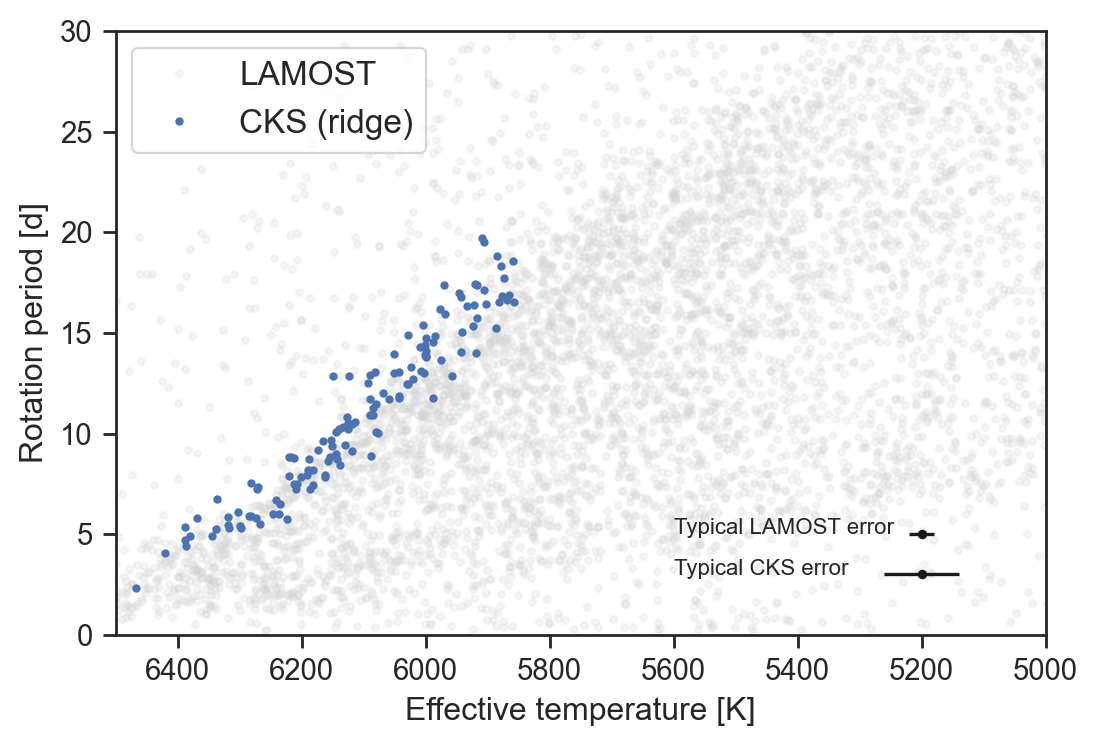

In [428]:
plt.plot(lam['Teff_lam'][ik], lam['Prot'][ik], '.', alpha=0.2, color='lightgrey', label='LAMOST', rasterized=True)
plt.plot(cks['p20_cks_steff'][ridge], cks['d21_prot'][ridge], 'o', ms=2, label='CKS (ridge)', rasterized=True)
plt.errorbar(5200,3,xerr=np.nanmedian(cks['p20_cks_steff_err1']),yerr=0,fmt='.',color='k', zorder=999)
plt.errorbar(5200,5,xerr=np.nanmedian(lam['e_Teff_lam'][lam['Teff_lam']>5800]),yerr=0,fmt='.',color='k', zorder=999)
plt.text(5600, 3, 'Typical CKS error', size=8)
plt.text(5600, 5, 'Typical LAMOST error', size=8)
plt.xlim(6500,5000)
plt.ylim(0,30)
plt.legend(prop={"size":12})
plt.xlabel('Effective temperature [K]')
plt.ylabel('Rotation period [d]')
plt.savefig('../figures/cks-lamost.pdf')
plt.show()

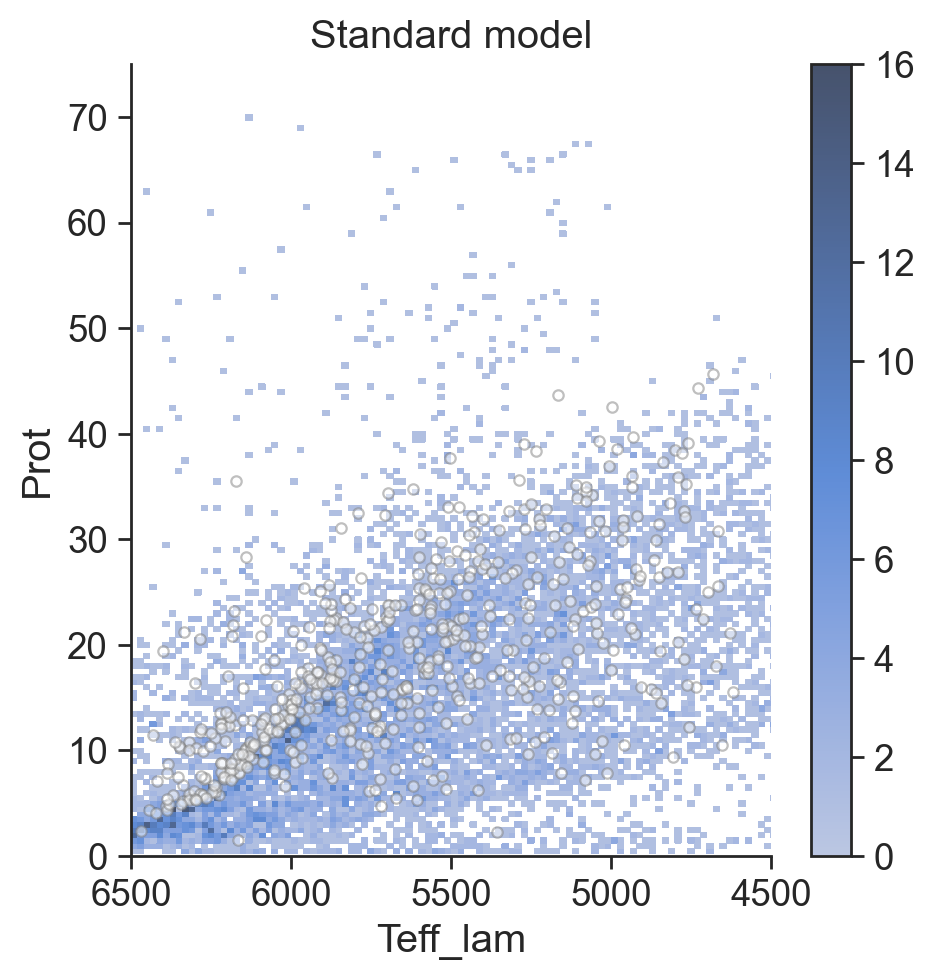

In [305]:
sns.displot(data=lam, x="Teff_lam", y="Prot", binwidth=(20, 0.5), cbar=True)
plt.scatter(cks['cks_Teff'], cks['d21_prot'], color='white', edgecolors='grey',  s=14, alpha=0.5)
plt.gca().invert_xaxis()
plt.xlim(6500,4500)
plt.ylim(0,75)
plt.title('Standard model')
#plt.savefig('../figures/std-model.pdf')
plt.show()

In [395]:
cks['cks_e_age'] = cks['cks_age'] - (10.**(cks['cks_logAiso']-cks['cks_e_logAiso'])/1.0e9)
cks['cks_E_age'] = (10.**(cks['cks_logAiso']+cks['cks_E_logAiso'])/1.0e9) - cks['cks_age']

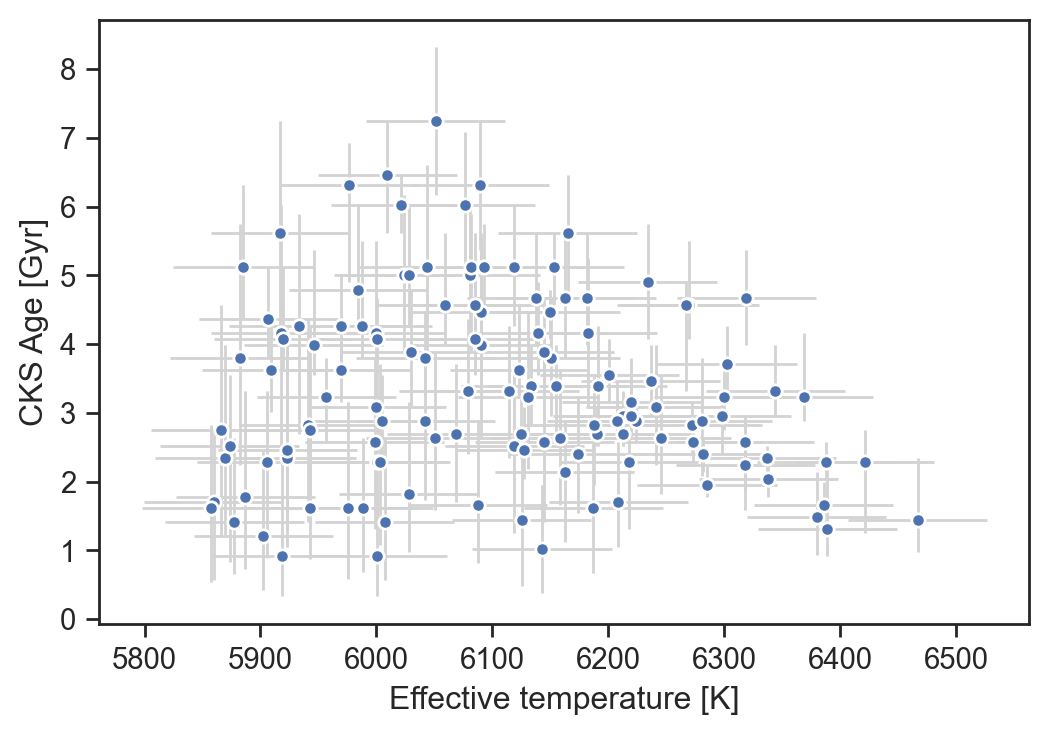

In [430]:
sns.set(font_scale=1.2, context="paper", style="ticks")

plt.errorbar(cks['p20_cks_steff'][ridge], cks['cks_age'][ridge], 
             xerr=[cks['cks_e_Teff'][ridge], cks['cks_E_Teff'][ridge]],
             yerr=[cks['cks_e_age'][ridge], cks['cks_E_age'][ridge]], fmt='o', mec='white', linewidth=1, ecolor='lightgrey')
plt.ylabel('CKS Age [Gyr]')
plt.xlabel('Effective temperature [K]')
plt.savefig('../figures/age-teff.pdf')
plt.show()